<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Amirreza Joediry
### Student ID: 401200277

# Import necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

# Define the MNIST dataset and data loader

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 90405761.61it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 19481456.07it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 70389319.27it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15981987.22it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Data Visualization

In [ ]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()


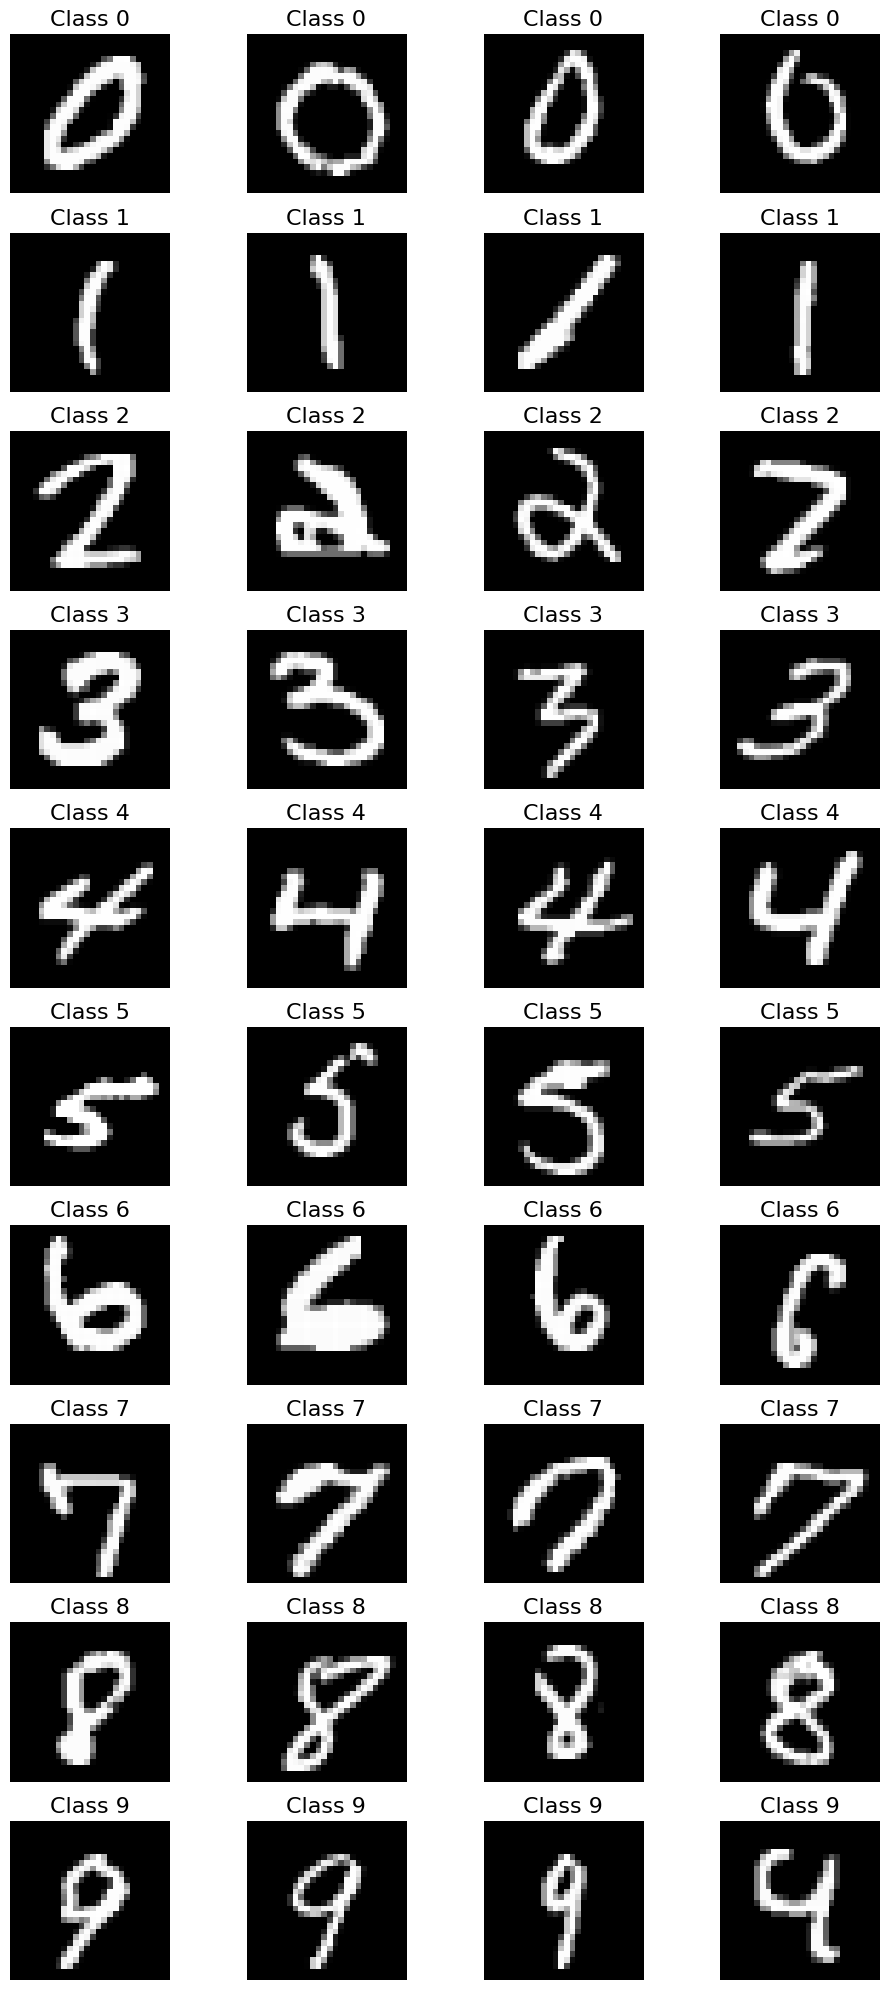

In [ ]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP)

Let's get started!

# 1) VAE --> MLP

In [ ]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()

        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encoder
        x = x.view(-1, 784)  # Flatten the input
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        # Reparameterization trick
        z = self.reparameterize(mu, logvar)

        # Decoder
        x_hat = self.decoder(z)

        return x_hat, mu, logvar


In [ ]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
    # Mean Squared Error (MSE) loss
    reconstruction_loss = F.mse_loss(recon, data, reduction='sum')

    # KL Divergence Loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total VAE Loss (combination of reconstruction and KL divergence losses)
    total_loss = reconstruction_loss + kl_divergence

    return total_loss

In [ ]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # Forward process
            recon, mu, logvar = model(data)

            # Flatten the data and recon tensors
            data = data.view(-1, 784)
            recon = recon.view(-1, 784)

            # Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # Save the best model to a file
    torch.save(best_model, 'best_vae_mlp_model_no_normalization.pth')
    print("Best model saved as 'best_vae_mlp_model_no_normalization.pth'")



##################################################
VAE-MLP Epoch [1/10], Loss: 46.93045797119141
Sample Images:


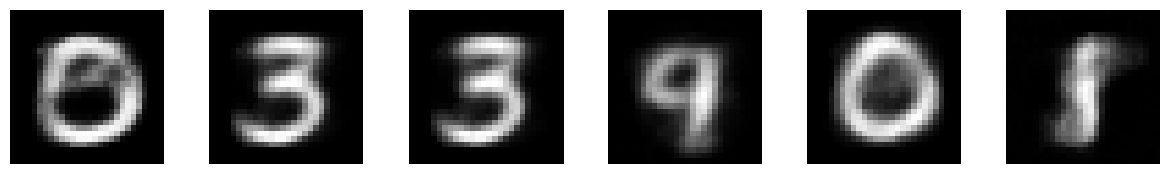


##################################################
VAE-MLP Epoch [2/10], Loss: 40.172929325358076
Sample Images:


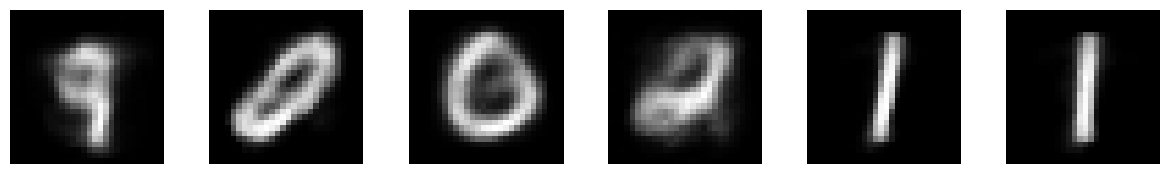


##################################################
VAE-MLP Epoch [3/10], Loss: 38.66047974243164
Sample Images:


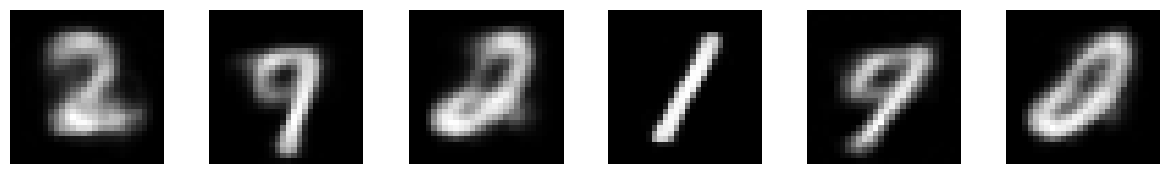


##################################################
VAE-MLP Epoch [4/10], Loss: 37.711390993245445
Sample Images:


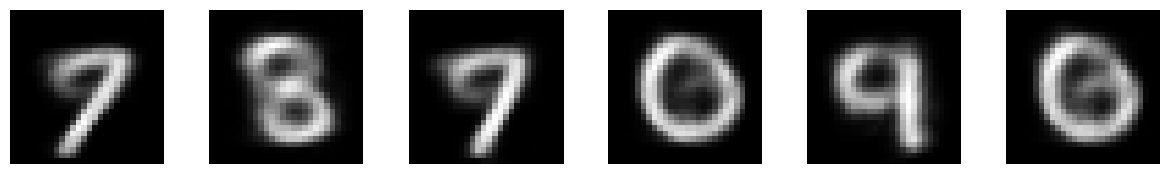


##################################################
VAE-MLP Epoch [5/10], Loss: 37.23235311279297
Sample Images:


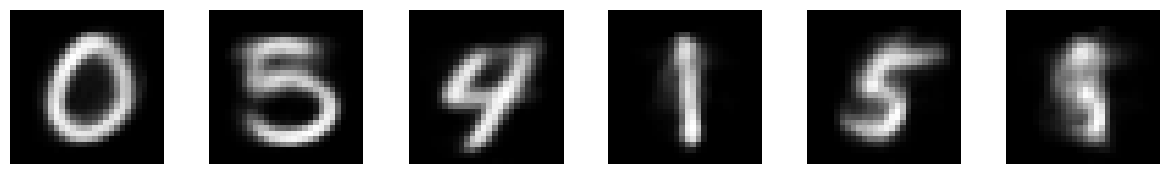


##################################################
VAE-MLP Epoch [6/10], Loss: 36.79882428588867
Sample Images:


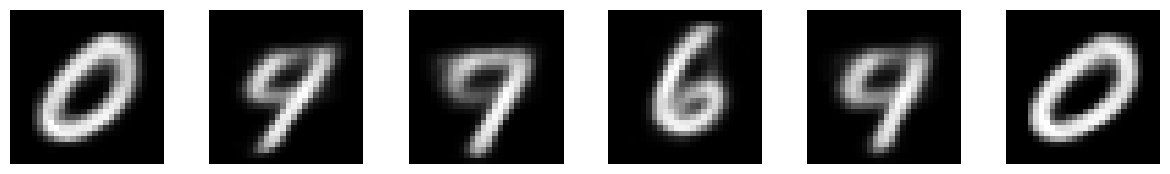


##################################################
VAE-MLP Epoch [7/10], Loss: 36.50944277750651
Sample Images:


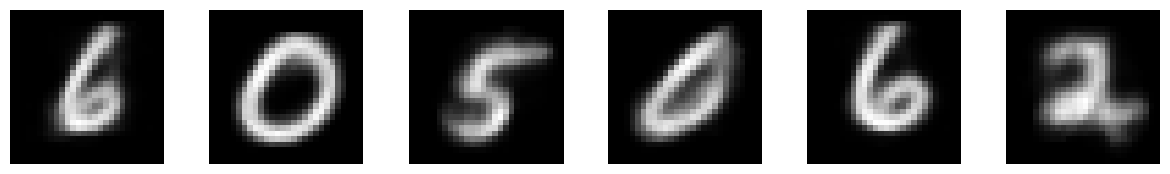


##################################################
VAE-MLP Epoch [8/10], Loss: 36.28671467895508
Sample Images:


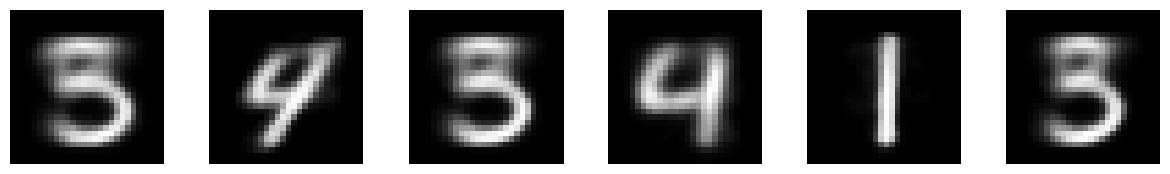


##################################################
VAE-MLP Epoch [9/10], Loss: 36.085385463460284
Sample Images:


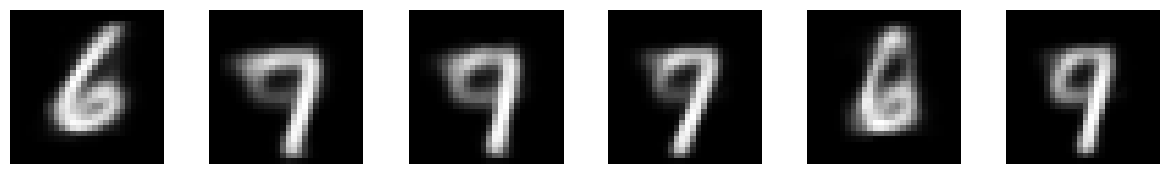


##################################################
VAE-MLP Epoch [10/10], Loss: 35.869029748535155
Sample Images:


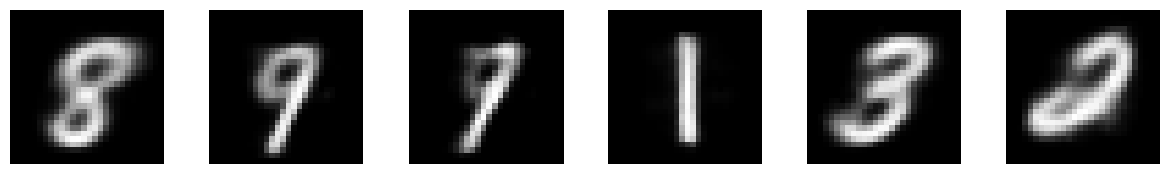

Best model saved as 'best_vae_mlp_model_no_normalization.pth'


In [ ]:
# Instantiate your VAE_MLP model with appropriate parameters
vae_mlp = VAE_MLP(input_dim=784, hidden_dim=256, latent_dim=2)

# Train the VAE-MLP model
train_vae_mlp(vae_mlp, train_loader, num_epochs=10, learning_rate=1e-3)


# 2) CVAE --> MLP

In [ ]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_class = nn.Linear(hidden_dim, num_classes)

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        # Flatten x and y
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # Concatenate x and y before passing them to the encoder
        xy = torch.cat([x, y], dim=1)

        # Encoder
        hidden = self.encoder(xy)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        class_logits = self.fc_class(hidden)

        # Reparameterization trick
        z = self.reparameterize(mu, logvar)

        # Concatenate z and y before passing them to the decoder
        zy = torch.cat([z, y], dim=1)

        # Decoder
        reconstructed = self.decoder(zy)

        return reconstructed, mu, logvar, class_logits


In [ ]:
# Define CVAE loss function

def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # Flatten the data tensor
    data = data.view(-1, 784)

    # Reconstruction loss (assuming input data is in [0, 1] range, use BCE loss)
    reconstruction_loss = F.mse_loss(recon, data, reduction='sum')

    # KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Cross-entropy loss for class prediction
    ce_loss = F.cross_entropy(class_logits, labels, reduction='sum')

    # Total CVAE loss (combination of reconstruction, KL divergence, and cross-entropy losses)
    total_loss = reconstruction_loss + kl_divergence + ce_loss

    return total_loss



In [ ]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            # One-hot encode the labels
            num_classes = 10  # Assuming 10 classes for MNIST
            labels_one_hot = F.one_hot(labels, num_classes).float()

            # Forward pass through the model and calculate the loss using cvae_loss
            recon, mu, logvar, class_logits = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels_one_hot)

            # Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # Save the best model to a file
    torch.save(best_model, 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################
CVAE-MLP Epoch [1/10], Loss: 40.23106976318359
Sample Images:


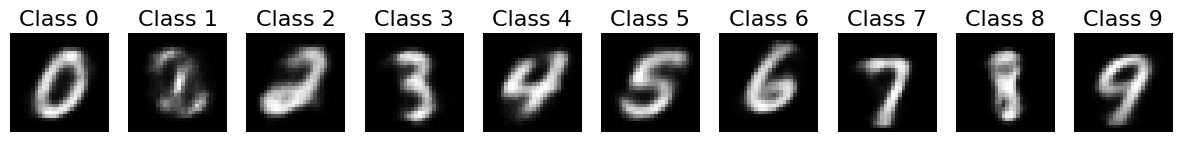


##################################################
CVAE-MLP Epoch [2/10], Loss: 32.667639457194014
Sample Images:


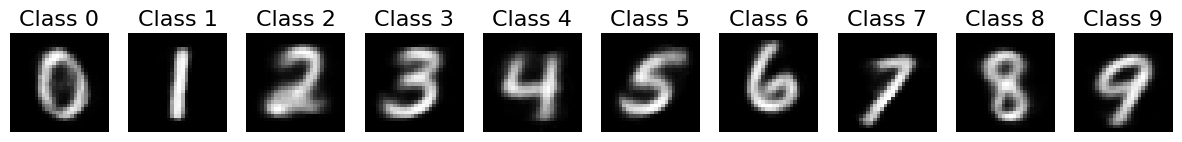


##################################################
CVAE-MLP Epoch [3/10], Loss: 31.568648154703776
Sample Images:


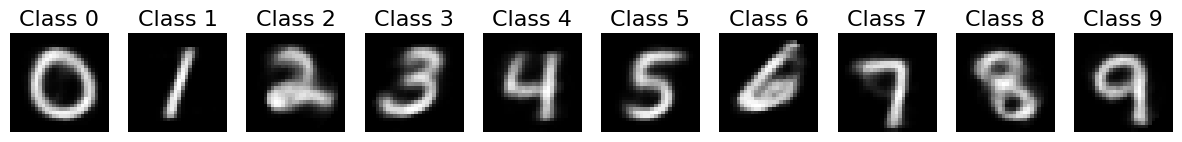


##################################################
CVAE-MLP Epoch [4/10], Loss: 31.004225223795572
Sample Images:


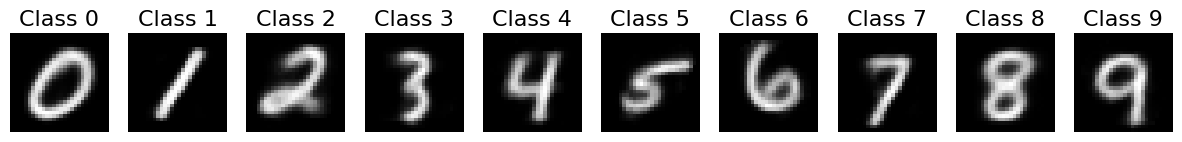


##################################################
CVAE-MLP Epoch [5/10], Loss: 30.679287446085613
Sample Images:


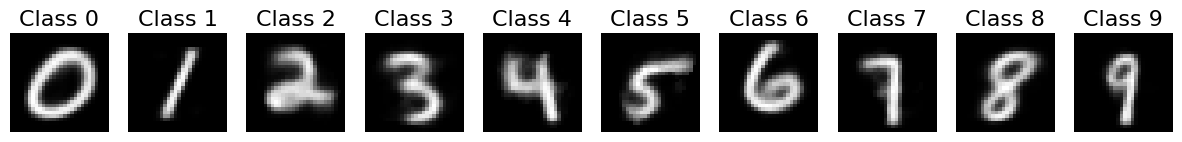


##################################################
CVAE-MLP Epoch [6/10], Loss: 30.47047863769531
Sample Images:


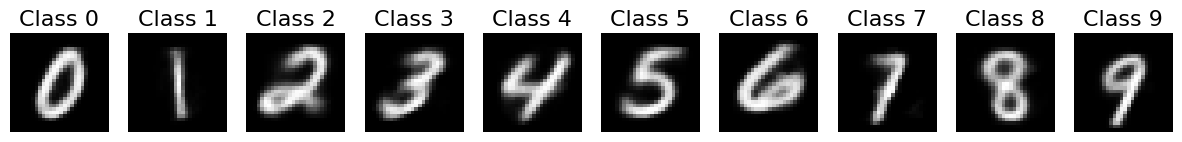


##################################################
CVAE-MLP Epoch [7/10], Loss: 30.301331823730468
Sample Images:


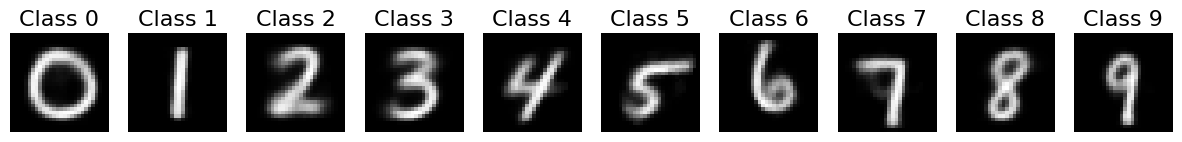


##################################################
CVAE-MLP Epoch [8/10], Loss: 30.155801862589517
Sample Images:


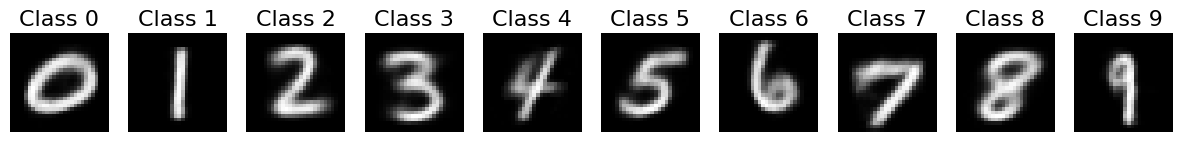


##################################################
CVAE-MLP Epoch [9/10], Loss: 30.048340397135416
Sample Images:


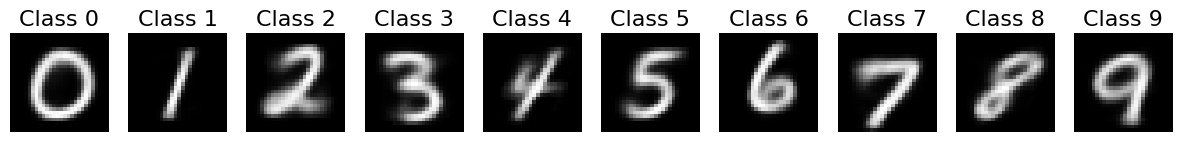


##################################################
CVAE-MLP Epoch [10/10], Loss: 29.94276216430664
Sample Images:


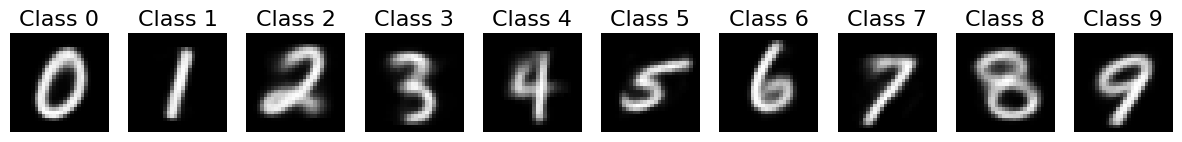

Best model saved as 'best_cvae_mlp_model.pth'


In [ ]:
cvae_mlp = CVAE_MLP(input_dim=784, hidden_dim=256, latent_dim=2, num_classes=10)

train_cvae_mlp(cvae_mlp, train_loader, num_epochs=10, learning_rate=1e-3)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


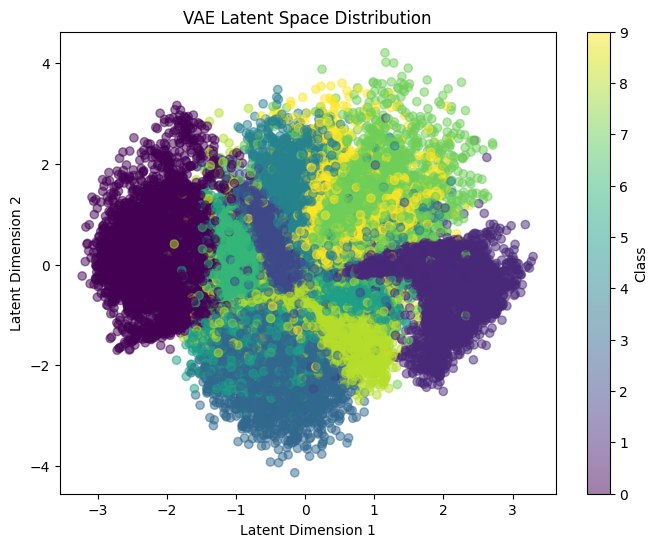

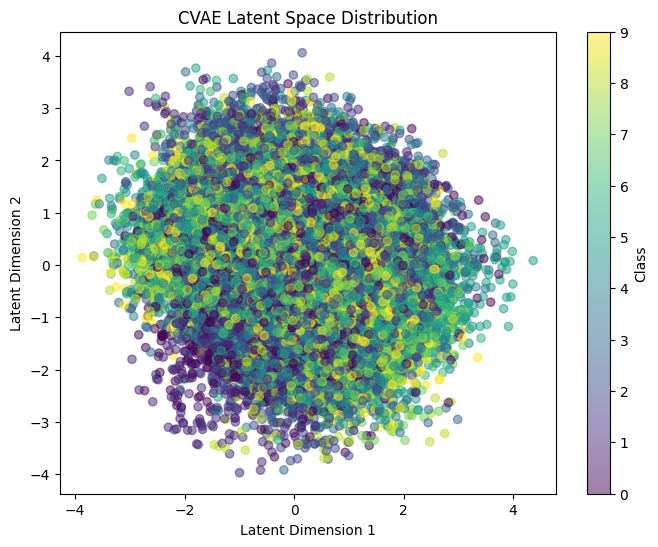

In [ ]:
def get_latent_space(model, dataloader):
    model.eval()
    latent_space = []
    labels = []

    with torch.no_grad():
        for data, label in dataloader:
            # Forward pass to get latent space representation
            if isinstance(model, VAE_MLP):
                _, mu, _ = model(data)
            elif isinstance(model, CVAE_MLP):
                _, mu, _, _ = model(data, F.one_hot(label, num_classes=10).float())
            else:
                raise ValueError("Unknown model type")

            latent_space.append(mu)
            labels.append(label)

    latent_space = torch.cat(latent_space, dim=0)
    labels = torch.cat(labels, dim=0)

    return latent_space, labels

# Function to visualize latent space distribution
def visualize_latent_space(latent_space, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(latent_space[:, 0], latent_space[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.title(title)
    plt.colorbar(label='Class')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_loader = DataLoader(mnist_dataset, batch_size=64, shuffle=True)

# Instantiate and load trained VAE model
vae_mlp = VAE_MLP(input_dim=784, hidden_dim=256, latent_dim=2)
vae_mlp.load_state_dict(torch.load('best_vae_mlp_model_no_normalization.pth'))
vae_mlp.eval()

# Get latent space representations for VAE
vae_latent_space, vae_labels = get_latent_space(vae_mlp, mnist_loader)

# Visualize latent space distribution for VAE
visualize_latent_space(vae_latent_space, vae_labels, title='VAE Latent Space Distribution')

# Instantiate and load trained CVAE model
cvae_mlp = CVAE_MLP(input_dim=784, hidden_dim=256, latent_dim=2, num_classes=10)
cvae_mlp.load_state_dict(torch.load('best_cvae_mlp_model.pth'))
cvae_mlp.eval()

# Get latent space representations for CVAE
cvae_latent_space, cvae_labels = get_latent_space(cvae_mlp, mnist_loader)

# Visualize latent space distribution for CVAE
visualize_latent_space(cvae_latent_space, cvae_labels, title='CVAE Latent Space Distribution')